<h2>PARTE EN SUCIO</h2>

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import json
import math
import random
from itertools import tee

In [2]:
def lectura(ruta_archivo: str):
    try:
        # Leer el contenido del archivo JSON
        with open(ruta_archivo, 'r', encoding='utf-8') as archivo:
            datos_json = json.load(archivo)

        # Acceder a todas las entradas de "galactic_object"
        objetos_galacticos = datos_json.get("galactic_object", {})

        if objetos_galacticos:
            map = {}

            # Iterar a través de todas las entradas de "galactic_object"
            for id_objeto, objeto_galactico in objetos_galacticos.items():
                # Acceder e imprimir o utilizar propiedades específicas de cada "galactic_object"
                coordenada = objeto_galactico["coordinate"]
                nombre = objeto_galactico["name"]["key"]
                hyperlane = objeto_galactico.get("hyperlane",[])

                # Verificar si la longitud de hyperlane es mayor que 0, para eliminar vértices anormales
                if len(hyperlane) > 0:
                    # Guardar la información necesaria en el diccionario
                    map[int(id_objeto)] = [nombre, [(i["to"], i["length"]) for i in hyperlane], (coordenada["x"], coordenada["y"])]
            return map
        else:
            raise ValueError("La clave 'galactic_object' no existe en los datos JSON.") 
    
    except Exception as e:
        print(f"Error al leer o analizar el archivo JSON: {e}")



In [3]:
partida = lectura('../output/output1.json')

In [4]:
def test_lectura(diccionario):
    # Imprimir los 3 primeros elementos
    print('Mostrando los tres primeros sistemas de la galaxia:')
    for r in list(diccionario.items())[:3]:
        print(r[0], ": ", r[1])
    # Imprimir puntos suspensivos
    print("...")
    # Imprimir los 3 últimos elementos
    print('Mostrando los tres últimos sistemas de la galaxia:')
    for r in list(diccionario.items())[-3:]:
        print(r[0], ": ", r[1])

In [5]:
def genera_grafo(diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafo = nx.Graph()
    for r in diccionarioaux:
        if len(diccionarioaux[r])>0:
            grafo.add_edges_from((r, k[0]) for k in diccionarioaux[r])
    componentes_conexas = list(nx.connected_components(grafo))

    # Encontrar la componente conexa más grande
    tamanos_componentes = [len(componente) for componente in componentes_conexas]
    indice_componente_a_conservar = tamanos_componentes.index(max(tamanos_componentes))
    componente_a_conservar = list(componentes_conexas[indice_componente_a_conservar])

    # Crear un nuevo grafo con solo la componente conexa más grande
    G_componente_grande = grafo.subgraph(componente_a_conservar).copy()
    for r in diccionario.copy():
        if r not in G_componente_grande:
            diccionario.pop(r)
    return G_componente_grande

In [6]:
mapa = genera_grafo(partida)

In [7]:
def test_genera_grafo(diccionario) -> None:
    grafoaux = genera_grafo(diccionario)
    diccionarioaux = nx.to_dict_of_lists(grafoaux)
    print('Mostrando las conexiones de los tres primeros sistemas de la galaxia:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Mostrando las conexiones de los tres últimos sistemas:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [8]:
def adjudica_pesos(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    for origen in diccionarioaux:
        for destino, peso in diccionarioaux[origen]:
            grafoaux[origen][destino]['weight'] = peso
        
    return grafoaux

In [9]:
pesos_mapa = adjudica_pesos(mapa, partida)

In [10]:
def test_adjudica_pesos(grafo, diccionario) -> None:
    grafoaux = adjudica_pesos(grafo, diccionario)
    diccionarioaux = {u: [(v, data['weight']) for v, data in grafoaux[u].items()] for u in grafoaux.nodes()}
    print('Distancias entre los primeros tres sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Distancias entre los tres últimos sistemas y sus conexiones:')
    [print(r[0],":",r[1]) for r in sorted(diccionarioaux.items())[-3:]]

In [11]:
def adjudica_posiciones(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionariox = {clave: diccionarioaux[clave][2][0] for clave in diccionarioaux}
    diccionarioy = {clave: diccionarioaux[clave][2][1] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionariox, 'x')
    nx.set_node_attributes(grafoaux, diccionarioy, 'y')
    return grafoaux

In [12]:
posiciones_mapa = adjudica_posiciones(pesos_mapa, partida)

In [13]:
def test_adjudica_posiciones(grafo, diccionario) -> None:
    grafoaux = adjudica_posiciones(grafo, diccionario)
    diccionarioaux = {u: (grafoaux.nodes[u]['x'], grafoaux.nodes[u]['y']) for u in grafoaux.nodes()}
    print('Coordenadas de los tres primeros sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Coordenadas de los tres últimos sistemas:')
    [print(u, ":", pos) for u, pos in sorted(diccionarioaux.items())[-3:]]

In [14]:
def adjudica_etiquetas(grafo, diccionario) -> nx.Graph:
    diccionarioaux = diccionario.copy()
    diccionarioaux = {clave: diccionarioaux[clave][0] for clave in diccionarioaux}
    grafoaux = grafo.copy()
    nx.set_node_attributes(grafoaux, diccionarioaux, 'Label')
    return grafoaux

In [15]:
mapa_completo = adjudica_etiquetas(posiciones_mapa, partida)

In [16]:
def test_adjudica_etiquetas(grafo, diccionario) -> None:
    grafoaux = adjudica_etiquetas(grafo, diccionario)
    diccionarioaux = {u: grafoaux.nodes[u]['Label'] for u in grafoaux.nodes()}
    print('Etiquetas correspondientes a los tres primeros sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[:3]]
    print("...")
    print('Etiquetas correspondientes a los tres últimos sistemas:')
    [print(u, ":", label) for u, label in sorted(diccionarioaux.items())[-3:]]

<h2><a name="Evolucion"></a><strong>6. Evolución sociológica del imperio</strong></h2>
<p>Una última cosa a considerar para el futuro de nuestra patria es la evolución de los seres que residen en ella, o incluso quienes no pertenezcan al imperio. Para evitar las sublevaciones en nuestro imperio.</p>
<p>Para estudiar estas evoluciones a lo largo del tiempo, debemos aplicar <strong><em>Raddichi</em></strong>.</p>
<p>Os estaréis preguntando a la hora de leer esto <strong>qué es Raddichi</strong>. Raddichi es un algoritmo real que consiste en la búsqueda de grupos de nodos que están interconectados entre ellos. Explicándolo de una manera lógica, si dos nodos están muy interconectados, es más probable que formen muchos ciclos de 3.</p>
<p>Podemos considerar la siguiente fórmula como una forma resumida de qué haremos con Raddichi para evaluar una arista:</p>
<p style='text-align: center;'><em>Número de triangulos formado por esa arista+1(para evitar caso 0)/min(gradovertice i -1, gradoverticej -1)</em></p>
<p>Así, al evaluar todas las aristas, la que tenga menos valor podemos decir que es la más prescindible y al quitarla generaría varias componentes conexas y disconexas entre sí. Esas componentes disconexas formarían una comunidad.</p>

In [17]:
def numero_de_triangulos(graph, i, j):
    """
    Calcula el número de triángulos formados por los vértices i y j mediante sus vecinos comunes en un grafo.

    Parameters:
        - graph: Grafo de entrada.
        - i: Primer vértice.
        - j: Segundo vértice.

    Returns:
        Número de triángulos formados por los vértices i, j y sus vecinos comunes.
    """
    # Encontrar vecinos comunes de i y j
    vecinos_comunes = set(graph.neighbors(i)) & set(graph.neighbors(j))

    # Contar triángulos formados por i, j y los vecinos comunes
    num_triangulos = 0
    for vecino in vecinos_comunes:
        if graph.has_edge(i, vecino) and graph.has_edge(j, vecino):
            num_triangulos += 1

    return num_triangulos

def radicchi(g, iteraciones=1, show=False, grafo_para_plotear=None):
    """
    Realiza una modificación en un grafo utilizando el algoritmo Radicchi para la detección de comunidades.
    Elimina aristas con coeficiente mínimo calculado según la fórmula de Radicchi.

    Parameters:
        - g: Grafo de entrada.
        - iteraciones: Número de veces que se ejecutará el algoritmo.
        - show: Booleano que indica si se mostrará la representación gráfica de las comunidades.
        - grafo_para_plotear: Grafo para representación gráfica (puede ser diferente al grafo de entrada).

    Returns:
        Un nuevo grafo con las aristas eliminadas y representación gráfica de las comunidades (si show=True).
    """
    
    # Copiar el grafo de entrada para no modificar el original
    G = g.copy()
    
    for _ in range(iteraciones):
        # Crear un diccionario para almacenar los coeficientes de las aristas
        dic = {}
        
        # Iterar sobre todas las aristas del grafo
        for arista in list(G.edges()):
            i = arista[0]
            j = arista[1]
            gradoi = G.degree(i)
            gradoj = G.degree(j)
            
            # Verificar que los grados no sean iguales a 1 para evitar divisiones por cero
            if not (gradoi==1 or gradoj==1):
                # Calcular el número de triángulos formados por i, j y sus vecinos comunes
                triangulos = numero_de_triangulos(G, i, j)
                # Calcular el coeficiente según la fórmula de Radicchi
                coeficiente = (triangulos+1)/min(gradoi-1, gradoj-1)
                dic[arista] = coeficiente
                
        # Encontrar el valor mínimo entre los coeficientes
        valor_minimo = min(dic.values())
        # Crear una lista de aristas con el coeficiente mínimo
        aristas = [clave for clave, valor in dic.items() if valor == valor_minimo]
        
        # Eliminar las aristas con el coeficiente mínimo
        for arista in aristas:
            G.remove_edge(arista[0], arista[1])
    
    if show:
        comunidades = list(nx.connected_components(G))
        if grafo_para_plotear is None:
            plotear_grafo_con_comunidades(g, comunidades)
        else:
            plotear_grafo_con_comunidades(grafo_para_plotear, comunidades)
    
    return G

def plotear_grafo_con_comunidades(grafo, comunidades):
    """
    Visualiza un grafo con nodos coloreados según las comunidades.

    Parameters:
        - grafo: Grafo a visualizar.
        - comunidades: Lista de conjuntos, cada uno representando una comunidad.

    Returns:
        None
    """
    
    # Lista de colores para las comunidades
    colores = ['r', 'g', 'b', 'y', 'c', 'm', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'lime', 'indigo',
           'teal', 'maroon', 'navy', 'sienna', 'orchid', 'darkgreen', 'saddlebrown', 'firebrick', 'slategray', 'darkcyan',
           'darkkhaki', 'darkmagenta', 'salmon', 'gold', 'lightblue', 'darkorchid', 'darkred', 'mediumseagreen', 'mediumvioletred',
           'seagreen', 'mediumturquoise', 'orangered', 'royalblue', 'tomato', 'palegreen', 'midnightblue', 'hotpink', 'peru',
           'deepskyblue', 'sienna', 'forestgreen', 'steelblue', 'dodgerblue', 'chocolate', 'goldenrod', 'greenyellow', 'lightcoral',
           'cornflowerblue', 'darkolivegreen', 'darkslategray', 'mediumaquamarine', 'darkorange', 'mediumspringgreen', 'dimgrey',
           'darkseagreen', 'dodgerblue', 'darkviolet', 'darkslateblue', 'crimson', 'orangered', 'darkgoldenrod', 'darkcyan',
           'darkkhaki', 'darkmagenta', 'darkred', 'darkgreen', 'darkblue', 'darkorange', 'darkolivegreen', 'darkorchid', 'darkseagreen',
           'darkslateblue', 'darkslategray', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dodgerblue', 'firebrick',
           'forestgreen', 'fuchsia', 'gold', 'goldenrod', 'green', 'greenyellow', 'grey', 'hotpink', 'indianred', 'indigo', 'khaki',
           'lawngreen', 'lightblue', 'lightcoral', 'lightgreen', 'lightgrey', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue',
           'lightslategray', 'lightsteelblue', 'lightyellow', 'lime', 'limegreen', 'magenta', 'maroon', 'mediumaquamarine', 'mediumblue',
           'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred',
           'midnightblue', 'navajowhite', 'navy', 'olive', 'orangered', 'orchid', 'palegoldenrod', 'palegreen', 'paleturquoise',
           'palevioletred', 'peru', 'pink', 'plum', 'powderblue', 'purple', 'red', 'rosybrown', 'royalblue', 'saddlebrown', 'salmon',
           'sandybrown', 'seagreen', 'sienna', 'silver', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'tan',
           'teal', 'thistle', 'tomato', 'turquoise', 'violet', 'wheat', 'white', 'whitesmoke', 'yellow', 'yellowgreen']
    
    posiciones = {nodo: (mapa_completo.nodes[nodo]['x'], mapa_completo.nodes[nodo]['y']) for nodo in mapa_completo.nodes}
    plt.figure(figsize=(20, 20))
    
    for i, comunidad in enumerate(comunidades):
        nx.draw_networkx_nodes(grafo, posiciones, nodelist=comunidad, node_color=colores[i % len(colores)], label=f'Comunidad {i + 1}')
    
    nx.draw_networkx_edges(grafo, posiciones, ax=None)
    nx.draw_networkx_labels(grafo, posiciones)
    
    plt.legend()
    plt.show()


<p>Vemos los resultados:</p>

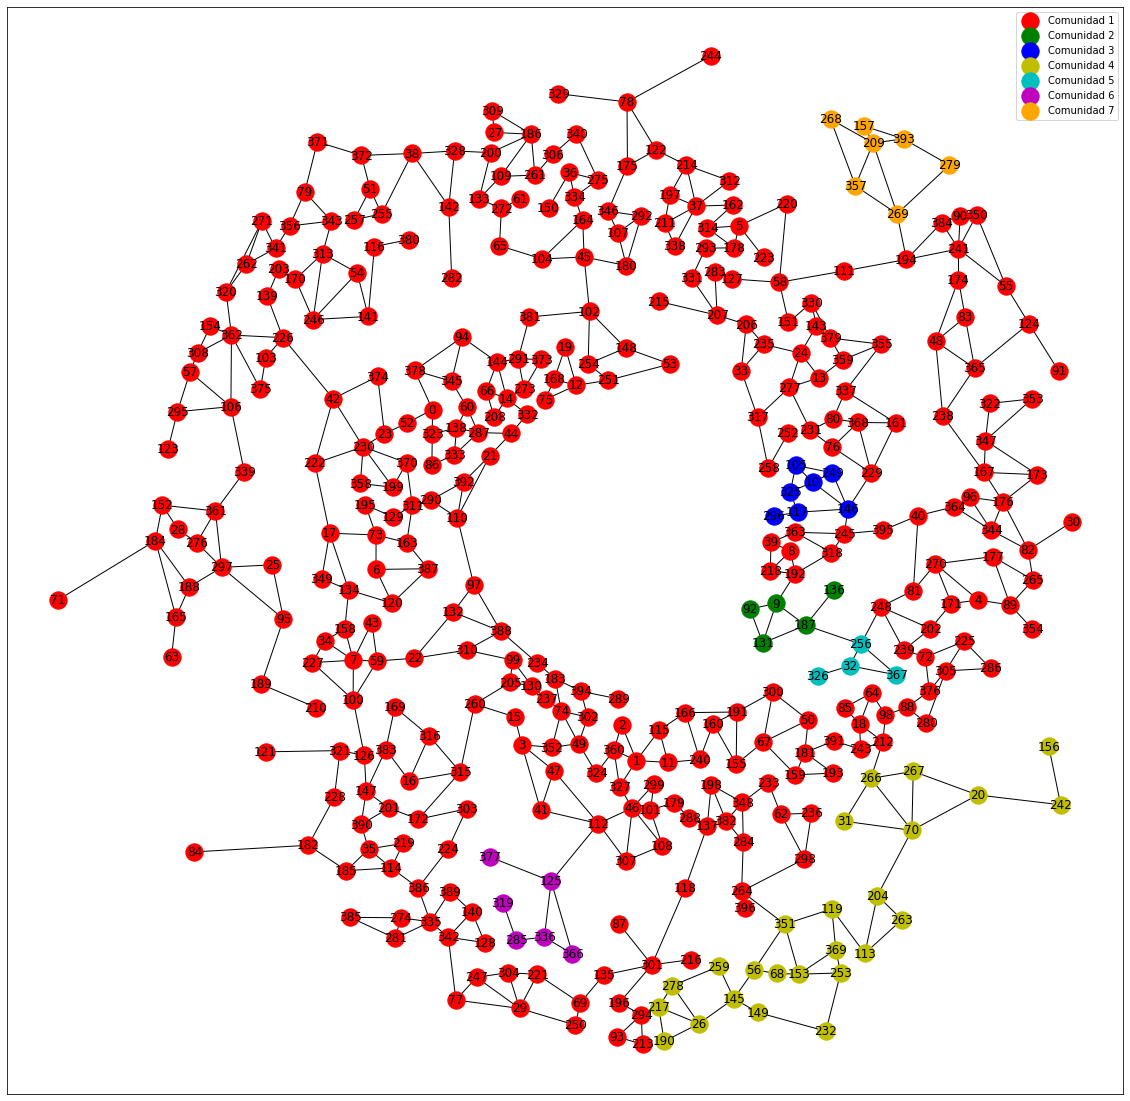

In [18]:
G = radicchi(mapa_completo)
comunidades = list(nx.connected_components(G))
plotear_grafo_con_comunidades(mapa_completo, comunidades)

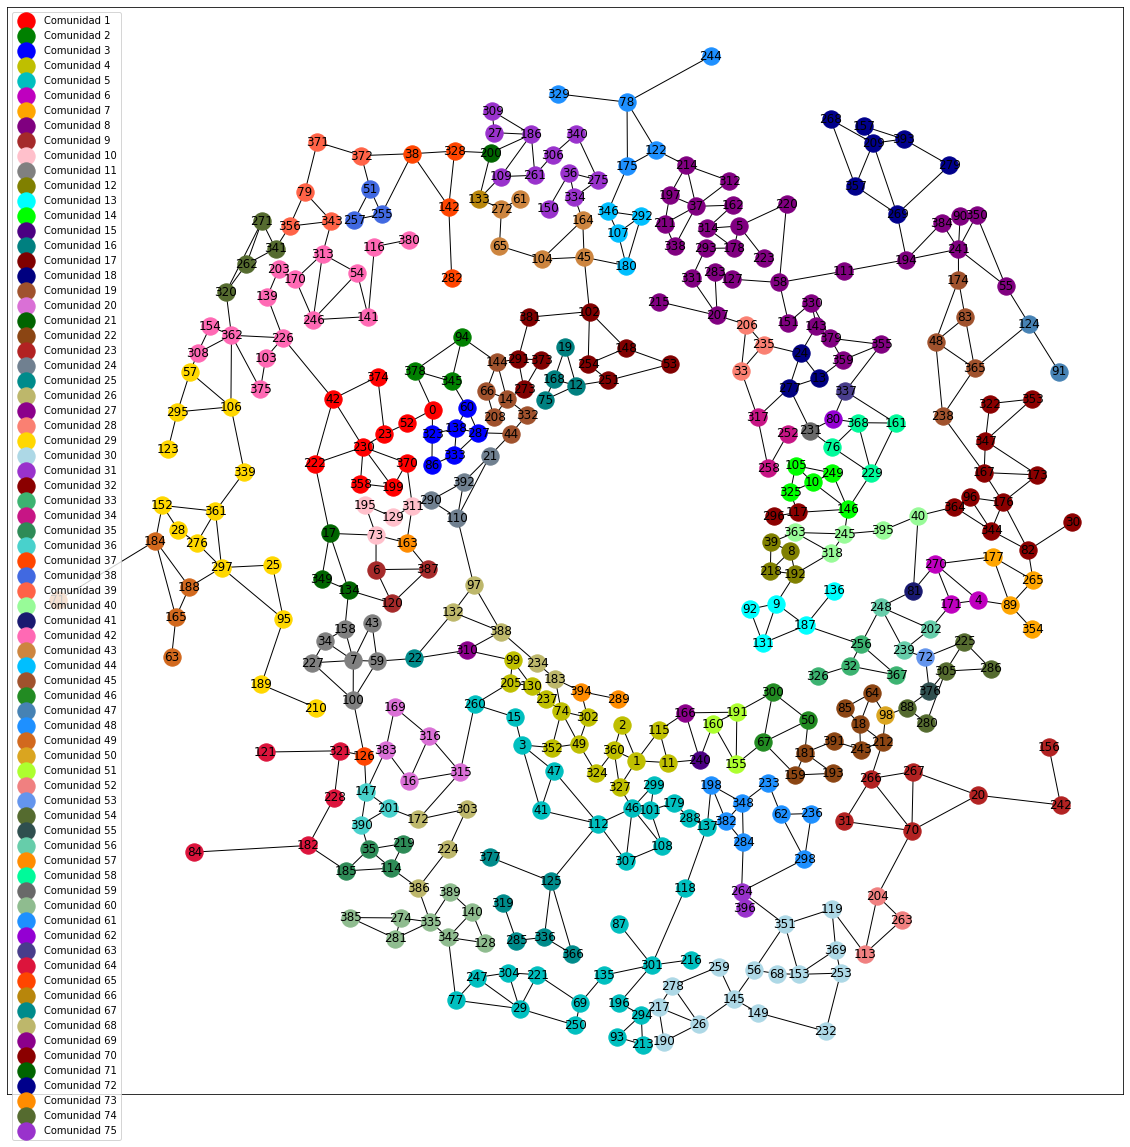

In [19]:
G = radicchi(G)
comunidades = list(nx.connected_components(G))
plotear_grafo_con_comunidades(mapa_completo, comunidades)

### Propuesta
<p>Previemante hemos mencionado la página de <strong>Ciencia de Datos</strong> para ver los estudios de centralidad de un grafo usando varias variables de funciones que nos ofrecía la librería <em>NetworkX</em>. En este caso, usando el mismo enlace, <em><a href='https://cienciadedatos.net/documentos/pygml03-analisis-redes-python-networkx'>Análisis de redes con Python y NetworkX</a></em> para en este caso estudiar las comunidades usando el algoritmo de <strong>Girvan-Newman</strong>.</p>